In [1]:
from fastai import *
from fastai.vision import *

In [2]:
DATA = untar_data(URLs.IMAGENETTE_160)

In [3]:
src = (ImageList.from_folder(DATA).filter_by_rand(0.3, seed=42)
                .split_by_folder(valid='val')
                .label_from_folder()
                .transform(([flip_lr(p=0.5)], []), size=160))
data = (src.databunch(bs=64, num_workers=6)
           .normalize(imagenet_stats))
data

ImageDataBunch;

Train: LabelList (3798 items)
x: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: CategoryList
n03028079,n03028079,n03028079,n03028079,n03028079
Path: /home/user/.fastai/data/imagenette-160;

Valid: LabelList (161 items)
x: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: CategoryList
n03028079,n03028079,n03028079,n03028079,n03028079
Path: /home/user/.fastai/data/imagenette-160;

Test: None

In [4]:
from fastai import layers

In [5]:
def conv_layer(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias:bool=None, is_1d:bool=False,
               norm_type:Optional[NormType]=NormType.Batch,  use_activ:bool=True, activ_fn:Callable=None, leaky:float=None,
               transpose:bool=False, init:Callable=nn.init.kaiming_normal_, self_attention:bool=False):
    "Create a sequence of convolutional (`ni` to `nf`), ReLU (if `use_activ`) and batchnorm (if `bn`) layers."
    activ_fn = ifnone(activ_fn, partial(relu, inplace=True, leaky=leaky))
    if padding is None: padding = (ks-1)//2 if not transpose else 0
    bn = norm_type in (NormType.Batch, NormType.BatchZero)
    if bias is None: bias = not bn
    conv_func = nn.ConvTranspose2d if transpose else nn.Conv1d if is_1d else nn.Conv2d
    conv = init_default(conv_func(ni, nf, kernel_size=ks, bias=bias, stride=stride, padding=padding), init)
    if   norm_type==NormType.Weight:   conv = weight_norm(conv)
    elif norm_type==NormType.Spectral: conv = spectral_norm(conv)
    layers = [conv]
    if use_activ: layers.append(activ_fn())
    if bn: layers.append((nn.BatchNorm1d if is_1d else nn.BatchNorm2d)(nf))
    if self_attention: layers.append(SelfAttention(nf))
    return nn.Sequential(*layers)

In [6]:
def simple_cnn(data, actns:Collection[int], kernel_szs:Collection[int]=None,
               strides:Collection[int]=None, bn=False, activ_fn=None,
               lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5,
               concat_pool:bool=True, bn_final:bool=False) -> nn.Sequential:
    "CNN with `conv_layer` defined by `actns`, `kernel_szs` and `strides`, plus batchnorm if `bn`."
    nl = len(actns)-1
    kernel_szs = ifnone(kernel_szs, [3]*nl)
    strides    = ifnone(strides   , [2]*nl)
    layers = [conv_layer(actns[i], actns[i+1], kernel_szs[i], stride=strides[i],
              norm_type=(NormType.Batch if bn and i<(len(strides)-1) else None), activ_fn=activ_fn) for i in range_of(strides)]
    nf_head = actns[-1]  * (2 if concat_pool else 1)
    head = create_head(nf_head, data.c, lin_ftrs=lin_ftrs, ps=ps, concat_pool=concat_pool, bn_final=bn_final)
    return nn.Sequential(*layers, head)

In [7]:
actns = [3,64,64,128,128,256,256,512,512]
strides = [1,2]*(len(actns)//2)

# Relu

In [48]:
mdl_relu = simple_cnn(data, actns=actns, strides=strides)
mdl_relu

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (5): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (6): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (7): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  

In [9]:
lrn = Learner(data, mdl_relu, metrics=[accuracy,top_k_accuracy])

In [10]:
lrn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.142710,2.980025,0.223602,0.739130,00:13
1,1.928795,1.946811,0.347826,0.813665,00:13
2,1.725688,1.865101,0.391304,0.826087,00:13
3,1.494881,1.939941,0.416149,0.795031,00:13
4,1.306941,1.135048,0.633540,0.950311,00:13


# Mish

In [42]:
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

In [43]:
mdl_mish = simple_cnn(data, actns=actns, strides=strides, activ_fn=Mish)
mdl_mish

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Mish()
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Mish()
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Mish()
  )
  (3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Mish()
  )
  (4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Mish()
  )
  (5): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Mish()
  )
  (6): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Mish()
  )
  (7): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Mish()
  )
  (8): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): Adap

In [10]:
lrn = Learner(data, mdl_mish, metrics=[accuracy,top_k_accuracy])

In [11]:
lrn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.076530,2.108528,0.304348,0.763975,00:16
1,1.843536,2.559659,0.267081,0.763975,00:15
2,1.580714,1.727570,0.360248,0.875776,00:15
3,1.308276,0.981897,0.658385,0.968944,00:15
4,1.075476,0.898451,0.708075,0.962733,00:15


## Mish CUDA

In [8]:
from mish_cuda import MishCuda

In [9]:
mdl_mish = simple_cnn(data, actns=actns, strides=strides, activ_fn=MishCuda)
mdl_mish

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MishCuda()
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MishCuda()
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MishCuda()
  )
  (3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MishCuda()
  )
  (4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MishCuda()
  )
  (5): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MishCuda()
  )
  (6): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MishCuda()
  )
  (7): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MishCuda()
  )
  (8): Sequential(
    (0): Adapti

In [10]:
lrn = Learner(data, mdl_mish, metrics=[accuracy,top_k_accuracy])

In [ ]:
lrn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,nan,nan,0.099379,0.000000,00:25
1,nan,nan,0.099379,0.000000,00:25
2,nan,nan,0.099379,0.000000,00:25


# Mish - addcmul

In [20]:
class Mish(nn.Module):
    def forward(self, x):
        return torch.addcmul(x.new_zeros(1), 1, x, torch.tanh(F.softplus(x)))

In [ ]:
t.new_zeros()

In [21]:
mdl_mish = simple_cnn(data, actns=actns, strides=strides, activ_fn=Mish)
mdl_mish

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Mish()
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Mish()
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Mish()
  )
  (3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Mish()
  )
  (4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Mish()
  )
  (5): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Mish()
  )
  (6): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Mish()
  )
  (7): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Mish()
  )
  (8): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): Adap

In [22]:
lrn = Learner(data, mdl_mish, metrics=[accuracy,top_k_accuracy])

In [23]:
lrn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.053012,2.246972,0.285714,0.720497,00:17
1,1.849435,1.712316,0.440994,0.844720,00:16
2,1.582252,1.471830,0.484472,0.875776,00:16
3,1.318823,1.000455,0.695652,0.937888,00:17
4,1.069603,0.911964,0.701863,0.950311,00:17


# Mish JIT

Not sure this is the right way to create a JIT module

In [14]:
class MishJit(torch.jit.ScriptModule):
    
    # Note: No self for forward or you get an error
    @torch.jit.script
    def forward(x):
        return x * torch.tanh(F.softplus(x))


This seems to be the recommended way:

In [419]:
MishJit = lambda: torch.jit.script(Mish())

In [25]:
mdl_mishjit = simple_cnn(data, actns=actns, strides=strides, activ_fn=MishJit)
mdl_mishjit

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MishJit()
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MishJit()
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MishJit()
  )
  (3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MishJit()
  )
  (4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MishJit()
  )
  (5): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MishJit()
  )
  (6): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MishJit()
  )
  (7): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MishJit()
  )
  (8): Sequential(
    (0): AdaptiveConcat

In [26]:
lrn = Learner(data, mdl_mishjit, metrics=[accuracy,top_k_accuracy])

In [27]:
lrn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.008492,2.380090,0.304348,0.726708,00:16
1,1.768086,1.570313,0.472050,0.888199,00:15
2,1.452909,1.287506,0.534162,0.944099,00:15
3,1.180452,0.982612,0.664596,0.956522,00:15
4,0.939465,0.796275,0.732919,0.968944,00:16


Doesn't look like any performance gain from JIT.

But you can see some stuff that's happening under the hood (code taken from https://github.com/pytorch/pytorch/blob/master/test/test_jit.py#L233):

In [37]:
mj = MishJit()
mj.graph

graph(%x.1 : Tensor):
  %6 : int = prim::Constant[value=20]()
  %5 : int = prim::Constant[value=1]()
  %7 : Tensor = aten::softplus(%x.1, %5, %6) # <ipython-input-14-d5e1efb10fcc>:5:31
  %8 : Tensor = aten::tanh(%7) # <ipython-input-14-d5e1efb10fcc>:5:20
  %9 : Tensor = aten::mul(%x.1, %8) # <ipython-input-14-d5e1efb10fcc>:5:16
  return (%9)

In [38]:
ds = mj.forward.get_debug_state()
fwd_plan = list(ds.execution_plans.values())[0]
ges = list(fwd_plan.code.grad_executor_states())
assert len(ges)==1
bwd_plan = ges[0]
bwd_plan.graph

graph(%0 : Tensor,
      %1 : Tensor,
      %2 : Tensor,
      %3 : Tensor,
      %4 : int[]?,
      %5 : int[]?):
  %6 : int = prim::Constant[value=1]() # <string>:154:39
  %grad_self.1 : Tensor, %grad_other.1 : Tensor = prim::GradOf[name="aten::mul"](%0)
    block0():
      %9 : Tensor = aten::mul(%0, %3) # <string>:11:30
      %grad_self.2 : Tensor = aten::_grad_sum_to_size(%9, %4) # <string>:11:30
      %11 : Tensor = aten::mul(%0, %2) # <string>:12:31
      %grad_other.2 : Tensor = aten::_grad_sum_to_size(%11, %5) # <string>:12:31
      -> (%grad_self.2, %grad_other.2)
  %13 : Tensor = prim::AutogradAdd(%1, %grad_other.1)
  %14 : Tensor = prim::GradOf[name="aten::tanh"](%13)
    block0():
      %15 : Tensor = aten::mul(%3, %3) # <string>:154:43
      %16 : Tensor = aten::neg(%15) # <string>:18:10
      %17 : Tensor = aten::add(%16, %6, %6) # <string>:18:10
      %18 : Tensor = aten::mul(%13, %17) # <string>:154:24
      -> (%18)
  return (%grad_self.1, %14)

## Mish Profiling

In [44]:
# Profiler doesn't like multiple workers
data_prof = (src.databunch(bs=64, num_workers=0)
                .normalize(imagenet_stats))

In [45]:
lrn = Learner(data_prof, mdl_mish, metrics=[accuracy,top_k_accuracy])
with torch.autograd.profiler.profile(use_cuda=True) as prof_mish:
    lrn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.090991,2.282425,0.242236,0.776398,00:19
1,1.843356,1.696035,0.397516,0.844720,00:18
2,1.575372,1.370669,0.515528,0.913043,00:19


In [46]:
print(prof_mish.key_averages().table(sort_by="cuda_time_total", row_limit=20))

-----------------------------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  
Name                                 Self CPU total %  Self CPU total   CPU total %      CPU total        CPU time avg     CUDA total %     CUDA total       CUDA time avg    Number of Calls  
-----------------------------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  
CudnnConvolutionBackward             0.07%            32.445ms         1.33%            593.029ms        418.806us        17.95%           18.293s          12.919ms         1416             
cudnn_convolution_backward           1.26%            560.585ms        1.26%            560.585ms        395.893us        17.94%           18.289s          12.916ms         1416             
conv2d                               0.02%  

## Relu Profiling

In [50]:
lrn = Learner(data_prof, mdl_relu, metrics=[accuracy,top_k_accuracy])
with torch.autograd.profiler.profile(use_cuda=True) as prof_relu:
    lrn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.144278,3.227488,0.198758,0.503106,00:16
1,1.964869,1.908126,0.310559,0.795031,00:16
2,1.797392,1.615858,0.447205,0.857143,00:16


In [52]:
print(prof_relu.key_averages().table(sort_by="cuda_time_total", row_limit=20))

-----------------------------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  
Name                                 Self CPU total %  Self CPU total   CPU total %      CPU total        CPU time avg     CUDA total %     CUDA total       CUDA time avg    Number of Calls  
-----------------------------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  
CudnnConvolutionBackward             0.08%            30.636ms         1.59%            590.901ms        417.303us        20.24%           18.338s          12.951ms         1416             
cudnn_convolution_backward           1.51%            560.265ms        1.51%            560.265ms        395.668us        20.24%           18.334s          12.948ms         1416             
conv2d                               0.02%  

## Profile Differences

In [410]:
keys = set([ev.key for prof in [prof_mish,prof_relu] for ev in prof.function_events])
ka_mish,ka_relu = prof_mish.key_averages(), prof_relu.key_averages()
ka_mish,ka_relu = [{ev.key: ev for ev in prof.key_averages()} for prof in [prof_mish,prof_relu]]
keys = set(list(ka_mish.keys()) + list(ka_relu.keys()))
keys -= {'to','contiguous','pin_memory'} # Dataloader stuff

In [411]:
ev_mish,ev_relu = [],[]
for key in keys:
    if ( key not in ka_mish or key not in ka_relu or 
         ka_mish[key].count != ka_relu[key].count or
         np.abs(ka_mish[key].cuda_time - ka_relu[key].cuda_time) > 100): # cuda_time in us
        if key in ka_mish: ev_mish.append(ka_mish[key])
        if key in ka_relu: ev_relu.append(ka_relu[key])

### Mish

In [412]:
print(torch.autograd.profiler.EventList(ev_mish).table(sort_by="cuda_time_total"))

----------------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  
Name                    Self CPU total %  Self CPU total   CPU total %      CPU total        CPU time avg     CUDA total %     CUDA total       CUDA time avg    Number of Calls  
----------------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  
mul                     12.55%           123.558ms        12.55%           123.558ms        26.339us         25.25%           4.034s           860.011us        4691             
MulBackward0            4.14%            40.766ms         13.87%           136.489ms        96.391us         16.60%           2.653s           1.874ms          1416             
add                     5.54%            54.531ms         5.54%            54.531ms         30.704us         

### Relu

In [413]:
print(torch.autograd.profiler.EventList(ev_relu).table(sort_by="cuda_time_total"))

----------------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  
Name                    Self CPU total %  Self CPU total   CPU total %      CPU total        CPU time avg     CUDA total %     CUDA total       CUDA time avg    Number of Calls  
----------------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  
ReluBackward1           5.15%            33.543ms         13.58%           88.343ms         55.457us         31.57%           1.335s           838.335us        1593             
threshold_backward      8.42%            54.799ms         8.42%            54.799ms         34.400us         31.40%           1.328s           833.837us        1593             
relu_                   3.73%            24.283ms         3.73%            24.283ms         14.506us         

The multiple kernel launches for Mish add up (Softplus, Tanh and some of the muls, from call count they're not all Mish).

## Autograd Function

You can't do anything inplace as this will cause errors in gradient calculation:

In [39]:
class MishInplace(nn.Module):
    def forward(self, x):
        return x.mul_(torch.tanh_(F.softplus(x)))

In [40]:
inp = torch.rand(5, requires_grad=True)
mdl = MishInplace()
out = torch.sum(mdl(inp))

RuntimeError: a leaf Variable that requires grad has been used in an in-place operation.

Autograd functions allow such inplace operations through saving stuff in forward to be used in backwards. But you have to do the gradient calculations then.
Being able to manually compute gradients would also be needed for a CUDA implementation as you can't really re-use the existing stuff for Softplus/Tanh (you'd have to have separate kernel launches and be back to where the straight Python is).

This seems to be the idea:

In [311]:
class MishFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inp):
        ctx.mark_dirty(inp)
        tsp = torch.tanh_(F.softplus(inp))
        ctx.save_for_backward(inp, tsp)
        return x.mul_(tsp)
    
    @staticmethod
    def backward(ctx, grad_out):
        inp,tsp = ctx.saved_tensors
        grad_tsp = torch.autograd.grad(grad_out, tsp)
        grad_inp = ...
        return grad_inp

Playing around with some of the autograd stuff:

In [314]:
grad = lambda o,i: torch.autograd.grad(o, i, retain_graph=True) # Need to use retain graph or you can only call once

In [312]:
x = torch.rand(3)
inp = x.clone().requires_grad_(True)
tsp = torch.tanh(F.softplus(inp))
out = x.mul(tsp)
l = torch.sum(out)

In [316]:
grad(l, inp) # Gradient of loss w.r.t input

(tensor([0.0430, 0.0735, 0.1787]),)

In [317]:
grad(l, tsp) # Gradient of loss w.r.t intermediate

(tensor([0.1375, 0.2415, 0.8298]),)

In [248]:
grad_out = torch.autograd.grad(l, out)
grad_out

(tensor([1., 1., 1.]),)

### CI Graph

In [302]:
txt = """Mish,87.48%,0.3967,-
Swish-1,87.32%,0.414,-0.3975 to 0.0844
E-Swish (?=1.75),87.49%,0.411,-0.2261 to 0.2539
GELU,87.37%,0.472,-0.3682 to 0.1499
ReLU,86.66%,0.584,-1.1179 to -0.5247
ELU(?=1.0),86.41%,0.3371,-1.2931 to -0.8556
Leaky ReLU(?=0.3),86.85%,0.4569,-0.8860 to -0.3774
RReLU,86.87%,0.4478,-0.8623 to -0.3595
SELU,83.91%,0.5995,-3.8713 to -3.2670
SoftPlus(? = 1),83.00%,1.4015,-4.7778 to -4.1735
HardShrink(? = 0.5),75.03%,0.98345,-12.8948 to -12.0035
Hardtanh,82.78%,0.4491,-4.9522 to -4.4486"""

In [304]:
sp = [l.split(',') for l in txt.split('\n')]
d = {n:v for n,v in zip(['Name','Acc','SD','CI'],  zip(*sp))}
df = pd.DataFrame.from_dict(d)
df

,Name,Acc,SD,CI
0,Mish,87.48%,0.3967,-
1,Swish-1,87.32%,0.414,-0.3975 to 0.0844
2,E-Swish (?=1.75),87.49%,0.411,-0.2261 to 0.2539
3,GELU,87.37%,0.472,-0.3682 to 0.1499
4,ReLU,86.66%,0.584,-1.1179 to -0.5247
5,ELU(?=1.0),86.41%,0.3371,-1.2931 to -0.8556
6,Leaky ReLU(?=0.3),86.85%,0.4569,-0.8860 to -0.3774
7,RReLU,86.87%,0.4478,-0.8623 to -0.3595
8,SELU,83.91%,0.5995,-3.8713 to -3.2670
9,SoftPlus(? = 1),83.00%,1.4015,-4.7778 to -4.1735


In [90]:
df.Name = df.Name.apply(lambda s: s.split('(')[0].strip())
df.Acc = df.Acc.str.slice(stop=5).astype(np.float)
df['ci_lo'] = df[1:].CI.apply(lambda s: s.split(' to ')[0]).astype(np.float) + df.iloc[0,1]
df['ci_hi'] = df[1:].CI.apply(lambda s: s.split(' to ')[1]).astype(np.float) + df.iloc[0,1]
df.ci_lo[0] = 87.3085
df.ci_hi[0] = 87.6515

In [174]:
df = df.drop(index=[10]) # Outlier

In [95]:
df[['Name','Acc','ci_lo','ci_hi']]

,Name,Acc,ci_lo,ci_hi
0,Mish,87.48,87.3085,87.6515
1,Swish-1,87.32,87.0825,87.5644
2,E-Swish (?=1.75),87.49,87.2539,87.7339
3,GELU,87.37,87.1118,87.6299
4,ReLU,86.66,86.3621,86.9553
5,ELU(?=1.0),86.41,86.1869,86.6244
6,Leaky ReLU(?=0.3),86.85,86.5940,87.1026
7,RReLU,86.87,86.6177,87.1205
8,SELU,83.91,83.6087,84.2130
9,SoftPlus(? = 1),83.00,82.7022,83.3065


In [175]:
errs = df[['ci_lo','ci_hi']].to_numpy() - df['Acc'].to_numpy()[:,None]

In [176]:
errs = np.abs(errs).transpose()

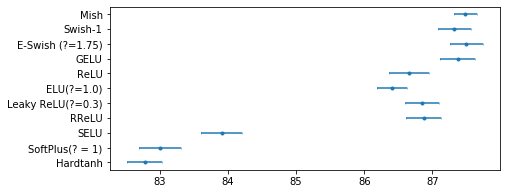

In [177]:
fig = plt.figure(figsize=(7,3))
plt.errorbar(df.Acc, range(len(df)), xerr=errs, ls='', marker='o', ms='3', capsize=1, capthick=0.5);
plt.yticks(range(len(df)), df.Name);
plt.gca().invert_yaxis()

In [5]:
ImageDataBunch.create_from_ll??

Signature:
ImageDataBunch.create_from_ll(
    lls: fastai.data_block.LabelLists,
    bs: int = 64,
    val_bs: int = None,
    ds_tfms: Union[Callable, Collection[Callable], NoneType] = None,
    num_workers: int = 1,
    dl_tfms: Union[Collection[Callable], NoneType] = None,
    device: torch.device = None,
    test: Union[pathlib.Path, str, NoneType] = None,
    collate_fn: Callable = <function data_collate at 0x7f6394e31dd0>,
    size: int = None,
    no_check: bool = False,
    resize_method: fastai.vision.image.ResizeMethod = None,
    mult: int = None,
    padding_mode: str = 'reflection',
    mode: str = 'bilinear',
    tfm_y: bool = False,
) -> 'ImageDataBunch'
Source:   
    @classmethod
    def create_from_ll(cls, lls:LabelLists, bs:int=64, val_bs:int=None, ds_tfms:Optional[TfmList]=None,
                num_workers:int=defaults.cpus, dl_tfms:Optional[Collection[Callable]]=None, device:torch.device=None,
                test:Optional[PathOrStr]=None, collate_fn:Callable=data_